# LeNet
 - [Tensorflow Dataset](https://www.tensorflow.org/datasets/catalog/overview)



---


---

### Cifar100 dataset (RGB images)
 - Dataset Perparation

In [7]:
import tensorflow as tf
print(f"Tensorflow Version : {tf.__version__}\n")

from tensorflow.keras.datasets import cifar100
import numpy as np

(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0            # Normalization

# train_images = np.expand_dims(train_images, axis=4).astype(np.float32)
train_images = train_images.astype(np.float32)
train_labels = train_labels.astype(np.int32)
test_images = test_images.astype(np.float32)
test_labels = test_labels.astype(np.int32)

print(f"\ntrain dataset (images) : {train_images.shape}")
print(f"train dataset (labels) : {train_labels.shape}\n")
print(f"test dataset (images) : {test_images.shape}")
print(f"test dataset (labels) : {test_labels.shape}\n")

print(f"labels : {len(np.unique(train_labels))}\n{np.unique(train_labels)}\n")


Tensorflow Version : 2.12.0


train dataset (images) : (50000, 32, 32, 3)
train dataset (labels) : (50000, 1)

test dataset (images) : (10000, 32, 32, 3)
test dataset (labels) : (10000, 1)

labels : 100
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]



In [8]:
batch_size = 32

train_batch = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(100).batch(batch_size)
test_batch = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(100).batch(batch_size)

print(f"train_batch : {len(train_batch)}개")
print(f"test_batch : {len(test_batch)}개\n")

for i, (images, labels) in enumerate(train_batch):
  if i == 0:
    print(f"batch shape (x, images) : {images.shape}")
    print(f"batch shape (y, labels) : {labels.shape}\n")
    break


train_batch : 1563개
test_batch : 313개

batch shape (x, images) : (32, 32, 32, 3)
batch shape (y, labels) : (32, 1)




---

### Implementation with cifar100

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

class LeNet_cifar100(Model):

  def __init__(self):
    super(LeNet_cifar100, self).__init__()

    self.fe = Sequential()
    self.fe.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='tanh', input_shape=(32, 32, 3)))
    self.fe.add(AveragePooling2D(pool_size=(2,2), strides=2))
    self.fe.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='tanh'))
    self.fe.add(AveragePooling2D(pool_size=(2,2), strides=2))
    self.fe.add(Conv2D(filters=256, kernel_size=(5,5), padding='valid', activation='tanh'))
    self.fe.add(Flatten())

    self.classifier = Sequential()
    self.classifier.add(Dense(units=256, activation='tanh'))
    self.classifier.add(Dense(units=100, activation='softmax'))

  def call(self, x):

    print(f"Input shape : {x.shape}")
    x = self.fe(x)
    x = self.classifier(x)
    print(f"Output shape : {x.shape}")

    return x


model = LeNet_cifar100()

In [10]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy as SCCE

model.compile(optimizer='adam',
              loss = SCCE(from_logits=False),
              metrics=['accuracy'])

model.build(train_images.shape)
model.summary()

Input shape : (50000, 32, 32, 3)
Output shape : (50000, 100)
Model: "le_net_cifar100_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 4096)              463552    
                                                                 
 sequential_3 (Sequential)   (50000, 100)              1074532   
                                                                 
Total params: 1,538,084
Trainable params: 1,538,084
Non-trainable params: 0
_________________________________________________________________


In [11]:
import pickle

def my_train(initializer=False):

  global model

  global drive_path
  global checkpoint_file

  global batch_size
  global epochs

  # References
  # https://www.tensorflow.org/tutorials/keras/save_and_load
  # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

  if initializer is False:

    # The model weights (that are considered the best) are loaded into the model.
    model.load_weights(drive_path+checkpoint_file)

    with open(drive_path+'accuracy_history', 'rb') as file:
      acc_history = pickle.load(file)

    with open(drive_path+'loss_history', 'rb') as file:
      loss_history = pickle.load(file)

  else:
    acc_history = list()
    loss_history = list()



  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath = drive_path+checkpoint_file,
      monitor = 'accuracy',
      save_best_only=True,
      mode = 'max',
      save_weights_only = True)

  history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[model_checkpoint_callback])

  acc_history.extend([accuracy*100 for accuracy in history.history['accuracy']])
  loss_history.extend(history.history['loss'])

  with open(drive_path+'accuracy_history', 'wb') as file:
    pickle.dump(acc_history, file)

  with open(drive_path+'loss_history', 'wb') as file:
    pickle.dump(loss_history, file)


# model.save('/content/drive/MyDrive/Study/programming/Colab_Notebooks/Tensorflow/models/lenet_cifar100')

# model.save('/content/drive/MyDrive/saved.model.hdf5')
# model.load_weights('/content/drive/MyDrive/saved.model.hdf5')

In [ ]:
drive_path = '/content/drive/MyDrive/Study/programming/Colab_Notebooks/Tensorflow/models/lenet_cifar100/training_1/'
checkpoint_file = 'cp.ckpt'
epochs = 4

# First training
my_train(initializer=True)

Epoch 1/4
1563/1563 [==============================] - 9s 5ms/step - loss: 3.3679 - accuracy: 0.2036
Epoch 2/4
1563/1563 [==============================] - 8s 5ms/step - loss: 3.3222 - accuracy: 0.2096
Epoch 3/4
1563/1563 [==============================] - 8s 5ms/step - loss: 3.2817 - accuracy: 0.2168
Epoch 4/4
1563/1563 [==============================] - 10s 6ms/step - loss: 3.2507 - accuracy: 0.2201


In [14]:
# Additional training
drive_path = '/content/drive/MyDrive/Study/programming/Colab_Notebooks/Tensorflow/models/lenet_cifar100/training_1/'
checkpoint_file = 'cp.ckpt'
epochs = 1

my_train()

1563/1563 [==============================] - 338s 216ms/step - loss: 1.8292 - accuracy: 0.5034


In [17]:
# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


313/313 - 15s - loss: 3.8226 - accuracy: 0.2454 - 15s/epoch - 49ms/step
Restored model, accuracy: 24.54%


In [18]:
with open(drive_path+'accuracy_history', 'rb') as file:
  acc_history = pickle.load(file)

with open(drive_path+'loss_history', 'rb') as file:
  loss_history = pickle.load(file)

len(acc_history)

251

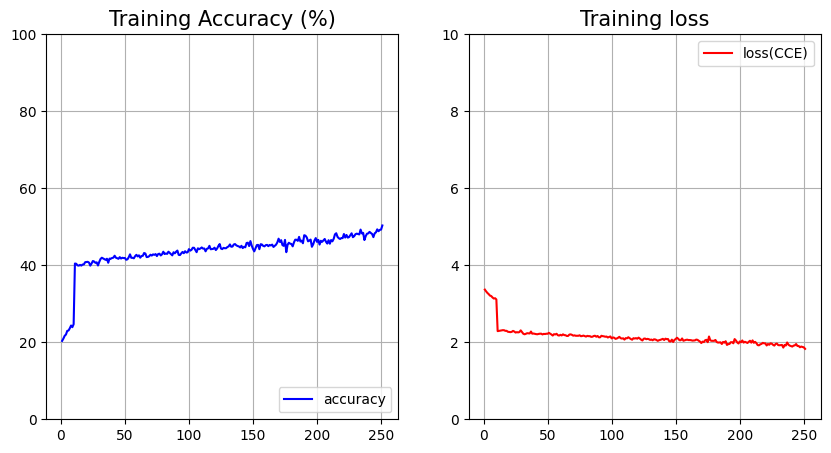

In [21]:
import matplotlib.pyplot as plt

epochs_range = list(range(1, 1+len(acc_history)))

# Visualization
fig, axes = plt.subplots(1,2, figsize=(10, 5))

axes[0].set_ylim(0, 100)
axes[0].plot(epochs_range, acc_history, color='b', label='accuracy')
axes[0].legend(loc='lower right')
axes[0].set_title('Training Accuracy (%)', fontsize=15)
axes[0].grid()

axes[1].set_ylim(0, 10)
axes[1].plot(epochs_range, loss_history, color='r', label='loss(CCE)')
axes[1].legend(loc='upper right')
axes[1].set_title('Training loss', fontsize=15)
axes[1].grid()

plt.show()



---
### Advanced Method


In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

loss_object = SparseCategoricalCrossentropy(from_logits=False)
optimizer = Adam(learning_rate=0.01)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


In [ ]:
# You can use tf.function to make graphs out of your programs.
@tf.function                                                                     #  속도, 이용성은 좋아지지만 비용이 많이 발생할 수 있음. 적용 시, 항상 좋은것은 아님.
def train_step(images, labels):
  # Record operations for automatic differentiation
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)


In [ ]:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  loss = loss_object(labels, predictions)

  test_loss(loss)
  test_accuracy(labels, predictions)


In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
  # Initialize
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_batch:
    train_step(images, labels)

  for t_images, t_labels in test_batch:
    test_step(images, labels)

  print(
      f"Epoch {epoch+1}, train_loss : {train_loss.result()}, "
      f"train_accuracy : {100-train_accuracy.result()*100}, "
      f"test_loss : {test_loss.result()}, "
      f"test_accuracy : {100-test_accuracy.result()*100}\n"
  )


Input shape : (32, 32, 32, 3)
Output shape : (32, 100)
Input shape : (32, 32, 32, 3)
Output shape : (32, 100)
Input shape : (16, 32, 32, 3)
Output shape : (16, 100)
Input shape : (16, 32, 32, 3)
Output shape : (16, 100)
Epoch 1, train_loss : 5.688675403594971, train_accuracy : 99.01200103759766, test_loss : 4.835206031799316, test_accuracy : 100.0

Epoch 2, train_loss : 5.678495407104492, train_accuracy : 99.01399993896484, test_loss : 4.985321044921875, test_accuracy : 100.0

Epoch 3, train_loss : 5.6820759773254395, train_accuracy : 98.9260025024414, test_loss : 4.66621732711792, test_accuracy : 100.0

Epoch 4, train_loss : 5.6917548179626465, train_accuracy : 98.98600006103516, test_loss : 4.639159679412842, test_accuracy : 93.75

Epoch 5, train_loss : 5.714461326599121, train_accuracy : 98.98600006103516, test_loss : 3.980787754058838, test_accuracy : 93.75

Epoch 6, train_loss : 5.709221363067627, train_accuracy : 98.97799682617188, test_loss : 5.136567115783691, test_accuracy : 9

In [ ]:

# model_cifar100 = LeNet_cifar100()
# losses_cifar100 = {}

# #####Forward Propagation######
# for i, (images, labels) in enumerate(train_ds):
#   predictions = model_cifar100(images)

#   loss_scce_func = SparseCategoricalCrossentropy()
#   loss_scce = loss_scce_func(labels, predictions)

#   losses_cifar100[i] = loss_scce

#   break

# losses_cifar100